# AI Screening Cost Sensitivity Analysis

This notebook runs the glaucoma model analysis **three times** with different AI screening costs:

1. **Low cost scenario**: AI screening cost = 0% of base case - relying on the DR infrastructure
2. **Base case scenario**: AI screening cost = base case value
3. **High cost scenario**: AI screening cost = 150% of base case

The analysis compares AI-enhanced vs traditional glaucoma screening across all three cost scenarios.

---

### 📊 Analysis Setup

All other parameters remain constant across scenarios - only the AI screening cost varies. This allows us to isolate the impact of AI screening cost on cost-effectiveness.

## Setup and Imports

In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import copy

sys.path.append('../src') 

from glaucoma_model.utils import (
    save_scenario_results
)
from glaucoma_model.analysis import (
    comprehensive_cost_effectiveness_analysis,
    create_summary_table
)

from glaucoma_model.parameters import (
    Parameter,
    GlaucomaParameters
)

from glaucoma_model.model import (
    BaseGlaucomaModel,
    AIGlaucomaModel,
    NonAIGlaucomaModel
)

from glaucoma_model.analysis import *

print("✓ Imports complete")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
✓ Imports complete


## Configuration

In [4]:
# Analysis parameters
N_ITERATIONS = 5000
YEARS = 30
STARTING_AGE = 61
MALE_PROPORTION = 0.55
RANDOM_SEED = 42

# Create a fresh model to get the base AI screening cost
temp_model = AIGlaucomaModel()
base_ai_cost = temp_model.params.costs['ai_screening'].mean
print(f"Base case AI screening cost: €{base_ai_cost:,.2f}")

# Define THREE AI screening cost scenarios
ai_screening_costs = {
    'Low': base_ai_cost - 3.65,    # removal of the AI cost component
    'Base': base_ai_cost,          # Base case
    'High': base_ai_cost + 2*3.65     # addition of additional equipment/maintenance costs
}

print("\n=== AI SCREENING COST SCENARIOS ===")
print(f"Scenario 1 (Low): AI screening cost = €{ai_screening_costs['Low']:,.2f} (no ai equipment cost - Diabetic retinopathy circuit)")
print(f"Scenario 2 (Base): AI screening cost = €{ai_screening_costs['Base']:,.2f}")
print(f"Scenario 3 (High): AI screening cost = €{ai_screening_costs['High']:,.2f} (addition of additional equipment/maintenance costs)")
print(f"\nAll scenarios use {N_ITERATIONS} iterations over {YEARS} years")
print(f"Starting age: {STARTING_AGE} years")

Base case AI screening cost: €11.65

=== AI SCREENING COST SCENARIOS ===
Scenario 1 (Low): AI screening cost = €8.00 (no ai equipment cost - Diabetic retinopathy circuit)
Scenario 2 (Base): AI screening cost = €11.65
Scenario 3 (High): AI screening cost = €18.95 (addition of additional equipment/maintenance costs)

All scenarios use 5000 iterations over 30 years
Starting age: 61 years


## Define Helper Function

This function runs the complete analysis for a single AI screening cost.

In [5]:
def run_single_scenario(ai_screening_cost, scenario_name):
    """
    Run the complete analysis for a single AI screening cost
    
    Parameters:
    -----------
    ai_screening_cost : float
        The AI screening cost per person
    scenario_name : str
        Name for this scenario
    
    Returns:
    --------
    dict : Results including summary table and comprehensive results
    """
    print(f"\n{'='*80}")
    print(f"SCENARIO: {scenario_name}")
    print(f"AI Screening Cost: €{ai_screening_cost:,.2f}")
    print(f"{'='*80}\n")
    
    # Initialize models
    model_ai = AIGlaucomaModel(starting_age=STARTING_AGE)
    model_ai.load_mortality_table_from_file(
        filepath_male='../data/male_mortality_2023.csv',
        filepath_female='../data/female_mortality_2023.csv',
        male_proportion=MALE_PROPORTION
    )
    
    model_non_ai = NonAIGlaucomaModel(starting_age=STARTING_AGE)
    model_non_ai.load_mortality_table_from_file(
        filepath_male='../data/male_mortality_2023.csv',
        filepath_female='../data/female_mortality_2023.csv',
        male_proportion=MALE_PROPORTION
    )
    
    # =========================================================================
    # UPDATE AI SCREENING COST - THIS IS THE KEY STEP
    # =========================================================================
    model_ai.params.costs['ai_screening'].mean = ai_screening_cost
    
    # Initial distribution (fixed proportions: 38 mild, 9 moderate, 7 severe, 0 VI, 0 dead)
    initial_dist = [38, 9, 7, 0, 0]
    initial_dist = np.array(initial_dist) / np.sum(initial_dist)
    
    # Run AI PSA
    print(f"Running AI Model PSA ({N_ITERATIONS} iterations)...")
    ai_psa_results = model_ai.run_probabilistic(
        n_iterations=N_ITERATIONS,
        initial_dist=initial_dist,
        years=YEARS,
        include_screening=True,
        population_type='general',
        random_seed=RANDOM_SEED,
        return_traces=True
    )
    
    # Run Non-AI PSA
    print(f"Running Non-AI Model PSA ({N_ITERATIONS} iterations)...")
    non_ai_psa_results = model_non_ai.run_probabilistic(
        n_iterations=N_ITERATIONS,
        initial_dist=initial_dist,
        years=YEARS,
        include_screening=True,
        population_type='general',
        random_seed=RANDOM_SEED,
        return_traces=True
    )
    
    # Adjust for sensitivity and specificity
    print("Adjusting for sensitivity and specificity...")
    ai_traces = ai_psa_results['trace_tensor']
    non_ai_traces = non_ai_psa_results['trace_tensor']
    variable_names = ai_psa_results['trace_variable_names']
    
    ai_eff0_psa_traces = copy.deepcopy(ai_traces)
    ai_eff0_psa_results = copy.deepcopy(ai_psa_results)
    
    sensitivity_value = model_ai.params.screening_accuracy['sensitivity'].mean
    
    # Adjust costs
    for var_name in ['Total_Cost', 'Total_Cost_Disc']:
        if var_name in variable_names:
            var_idx = variable_names.index(var_name)
            ai_eff0_psa_traces[:, :, var_idx] = (
                sensitivity_value * ai_traces[:, :, var_idx] +
                (1 - sensitivity_value) * non_ai_traces[:, :, var_idx]
            )
    
    # Adjust QALYs
    qaly_vars = ['Total_QALY', 'Total_QALY_Disc', 'QALY_Mild', 'QALY_Moderate', 'QALY_Severe', 'QALY_VI']
    for var_name in qaly_vars:
        if var_name in variable_names:
            var_idx = variable_names.index(var_name)
            ai_eff0_psa_traces[:, :, var_idx] = (
                sensitivity_value * ai_traces[:, :, var_idx] +
                (1 - sensitivity_value) * non_ai_traces[:, :, var_idx]
            )
    
    ai_eff0_psa_results['trace_tensor'] = ai_eff0_psa_traces
    
    # Add screening costs (using the updated AI screening cost)
    idx1 = variable_names.index('Total_Cost')
    idx2 = variable_names.index('Total_Cost_Disc')
    
    prevalence = model_ai.params.screening_params['prevalence_general'].mean
    
    # AI screening costs (adjusted with the new cost)
    ai_screening_per_case = (1/prevalence) * ai_screening_cost
    ai_eff0_psa_results['trace_tensor'][:, 0, idx1] += ai_screening_per_case
    ai_eff0_psa_results['trace_tensor'][:, 0, idx2] += ai_screening_per_case
    
    # False positive costs
    specificity = model_ai.params.screening_accuracy['specificity'].mean
    human_screening_cost = model_ai.params.costs['human_screening'].mean
    false_positives_per_case = ((1 - prevalence) / prevalence) * (1 - specificity)
    
    ai_eff0_psa_results['trace_tensor'][:, 0, idx1] += false_positives_per_case * human_screening_cost
    ai_eff0_psa_results['trace_tensor'][:, 0, idx2] += false_positives_per_case * human_screening_cost
    
    # Run comprehensive analysis
    print("Running comprehensive cost-effectiveness analysis...")
    comprehensive_results = comprehensive_cost_effectiveness_analysis(
        ai_eff0_psa_results, non_ai_psa_results,
        time_horizons=[5, 10, 15, 20, 30],
        thresholds=[0, 20000, 50000, 75000, 100000, 150000, 200000],
        confidence_level=0.95,
        discounted=True
    )
    
    summary_table = create_summary_table(comprehensive_results)
    
    return {
        'scenario_name': scenario_name,
        'ai_screening_cost': ai_screening_cost,
        'comprehensive_results': comprehensive_results,
        'summary_table': summary_table,
        'ai_psa_results': ai_psa_results,
        'non_ai_psa_results': non_ai_psa_results,
        'ai_eff0_psa_results': ai_eff0_psa_results
    }

print("✓ Helper function defined")

✓ Helper function defined


## Scenario 1: Low AI Screening Cost (DR circuit)

Running analysis with AI screening cost = 50% of base case

In [14]:
results_low = run_single_scenario(
    ai_screening_cost=ai_screening_costs['Low'],
    scenario_name="Low AI Screening Cost (DR infrastructure only)"
)


SCENARIO: Low AI Screening Cost (DR infrastructure only)
AI Screening Cost: €8.00

Applied Non-AI cost structure: Only VI patients incur costs
Running AI Model PSA (5000 iterations)...
Running 5000 PSA iterations for AI Enhanced Model (Starting Age: 61)...
  AI Model Iteration 100/5000
  AI Model Iteration 200/5000
  AI Model Iteration 300/5000
  AI Model Iteration 400/5000
  AI Model Iteration 500/5000
  AI Model Iteration 600/5000
  AI Model Iteration 700/5000
  AI Model Iteration 800/5000
  AI Model Iteration 900/5000
  AI Model Iteration 1000/5000
  AI Model Iteration 1100/5000
  AI Model Iteration 1200/5000
  AI Model Iteration 1300/5000
  AI Model Iteration 1400/5000
  AI Model Iteration 1500/5000
  AI Model Iteration 1600/5000
  AI Model Iteration 1700/5000
  AI Model Iteration 1800/5000
  AI Model Iteration 1900/5000
  AI Model Iteration 2000/5000
  AI Model Iteration 2100/5000
  AI Model Iteration 2200/5000
  AI Model Iteration 2300/5000
  AI Model Iteration 2400/5000
  AI Mo

### Summary Table - Low Cost Scenario

In [15]:
print("\n=== LOW AI COST SCENARIO - SUMMARY TABLE ===")
print(results_low['summary_table'].to_string(index=False))

# Display as DataFrame for better formatting
display(results_low['summary_table'])


=== LOW AI COST SCENARIO - SUMMARY TABLE ===
Time_Horizon Incremental_Cost_Mean Incremental_Cost_95CI Incremental_QALY_Mean Incremental_QALY_95CI     ICER ICER_Mean ICER_Median             ICER_95CI Prob_CE_20k Prob_CE_50k Prob_CE_100k
     5 years                  €737     [€-1,961, €3,483]                 0.068       [-0.194, 0.326]  €10,791    €2,835      €2,316 [€-143,127, €134,837]       65.7%       77.3%        81.5%
    10 years               €-1,407     [€-8,022, €4,830]                 0.219       [-0.357, 0.786]  €-6,411   €-2,737     €-3,279 [€-140,000, €122,348]       83.7%       88.1%        89.5%
    15 years               €-5,138    [€-16,354, €5,141]                 0.419       [-0.524, 1.346] €-12,267   €-7,200     €-6,479 [€-119,997, €106,172]       91.9%       93.5%        94.2%
    20 years               €-8,932    [€-24,414, €5,102]                 0.638       [-0.674, 1.918] €-14,002   €-8,197     €-8,375 [€-109,572, €109,560]       95.2%       96.0%        96.2%

,Time_Horizon,Incremental_Cost_Mean,Incremental_Cost_95CI,Incremental_QALY_Mean,Incremental_QALY_95CI,ICER,ICER_Mean,ICER_Median,ICER_95CI,Prob_CE_20k,Prob_CE_50k,Prob_CE_100k
0,5 years,€737,"[€-1,961, €3,483]",0.068,"[-0.194, 0.326]","€10,791","€2,835","€2,316","[€-143,127, €134,837]",65.7%,77.3%,81.5%
1,10 years,"€-1,407","[€-8,022, €4,830]",0.219,"[-0.357, 0.786]","€-6,411","€-2,737","€-3,279","[€-140,000, €122,348]",83.7%,88.1%,89.5%
2,15 years,"€-5,138","[€-16,354, €5,141]",0.419,"[-0.524, 1.346]","€-12,267","€-7,200","€-6,479","[€-119,997, €106,172]",91.9%,93.5%,94.2%
3,20 years,"€-8,932","[€-24,414, €5,102]",0.638,"[-0.674, 1.918]","€-14,002","€-8,197","€-8,375","[€-109,572, €109,560]",95.2%,96.0%,96.2%
4,30 years,"€-11,815","[€-30,387, €5,301]",0.952,"[-0.760, 2.587]","€-12,414","€-10,697","€-8,888","[€-111,155, €83,463]",96.7%,97.1%,97.3%


### Key Results - Low Cost Scenario

In [16]:
for years in [5, 10, 30]:
    print(f"\n=== {years}-YEAR RESULTS (Low AI Cost) ===")
    results = results_low['comprehensive_results'][f'{years}_years']['summary']
    print(f"ICER: €{results['incremental_cost_mean']/results['incremental_qaly_mean']:,.0f}  ICER (95% CI): €{results['icer_mean']:,.0f} [{results['icer_ci'][0]:,.0f}, {results['icer_ci'][1]:,.0f}]")
    print(f"Incremental Cost: €{results['incremental_cost_mean']:,.0f}")
    print(f"Incremental QALY: {results['incremental_qaly_mean']:.3f}")
    print(f"Probability cost-effective at €20k/QALY: {results['prob_cost_effective_20k']:.1f}%")
    print(f"Probability cost-effective at €50k/QALY: {results['prob_cost_effective_50k']:.1f}%")
    print(f"Probability cost-effective at €100k/QALY: {results['prob_cost_effective_100k']:.1f}%")


=== 5-YEAR RESULTS (Low AI Cost) ===
ICER: €10,791  ICER (95% CI): €2,835 [-143,127, 134,837]
Incremental Cost: €737
Incremental QALY: 0.068
Probability cost-effective at €20k/QALY: 65.7%
Probability cost-effective at €50k/QALY: 77.3%
Probability cost-effective at €100k/QALY: 81.5%

=== 10-YEAR RESULTS (Low AI Cost) ===
ICER: €-6,411  ICER (95% CI): €-2,737 [-140,000, 122,348]
Incremental Cost: €-1,407
Incremental QALY: 0.219
Probability cost-effective at €20k/QALY: 83.7%
Probability cost-effective at €50k/QALY: 88.1%
Probability cost-effective at €100k/QALY: 89.5%

=== 30-YEAR RESULTS (Low AI Cost) ===
ICER: €-12,414  ICER (95% CI): €-10,697 [-111,155, 83,463]
Incremental Cost: €-11,815
Incremental QALY: 0.952
Probability cost-effective at €20k/QALY: 96.7%
Probability cost-effective at €50k/QALY: 97.1%
Probability cost-effective at €100k/QALY: 97.3%


### Save Low Cost Results

In [17]:
results_low['summary_table'].to_csv('../data/ai_cost_low_summary.csv', index=False)
print("✓ Low AI cost scenario results saved to ../data/ai_cost_low_summary.csv")

✓ Low AI cost scenario results saved to ../data/ai_cost_low_summary.csv


## Scenario 2: Base Case AI Screening Cost

Running analysis with AI screening cost = base case value

In [10]:
results_base = run_single_scenario(
    ai_screening_cost=ai_screening_costs['Base'],
    scenario_name="Base Case AI Screening Cost"
)


SCENARIO: Base Case AI Screening Cost
AI Screening Cost: €11.65

Applied Non-AI cost structure: Only VI patients incur costs
Running AI Model PSA (5000 iterations)...
Running 5000 PSA iterations for AI Enhanced Model (Starting Age: 61)...
  AI Model Iteration 100/5000
  AI Model Iteration 200/5000
  AI Model Iteration 300/5000
  AI Model Iteration 400/5000
  AI Model Iteration 500/5000
  AI Model Iteration 600/5000
  AI Model Iteration 700/5000
  AI Model Iteration 800/5000
  AI Model Iteration 900/5000
  AI Model Iteration 1000/5000
  AI Model Iteration 1100/5000
  AI Model Iteration 1200/5000
  AI Model Iteration 1300/5000
  AI Model Iteration 1400/5000
  AI Model Iteration 1500/5000
  AI Model Iteration 1600/5000
  AI Model Iteration 1700/5000
  AI Model Iteration 1800/5000
  AI Model Iteration 1900/5000
  AI Model Iteration 2000/5000
  AI Model Iteration 2100/5000
  AI Model Iteration 2200/5000
  AI Model Iteration 2300/5000
  AI Model Iteration 2400/5000
  AI Model Iteration 2500

### Summary Table - Base Cost Scenario

In [11]:
print("\n=== BASE AI COST SCENARIO - SUMMARY TABLE ===")
print(results_base['summary_table'].to_string(index=False))

# Display as DataFrame for better formatting
display(results_base['summary_table'])


=== BASE AI COST SCENARIO - SUMMARY TABLE ===
Time_Horizon Incremental_Cost_Mean Incremental_Cost_95CI Incremental_QALY_Mean Incremental_QALY_95CI     ICER ICER_Mean ICER_Median             ICER_95CI Prob_CE_20k Prob_CE_50k Prob_CE_100k
     5 years                  €817     [€-1,902, €3,569]                 0.070       [-0.192, 0.328]  €11,637    €2,949      €1,766 [€-149,461, €133,426]       64.7%       76.9%        81.3%
    10 years               €-1,315     [€-7,939, €4,944]                 0.222       [-0.358, 0.789]  €-5,916   €-2,122     €-3,124 [€-127,559, €123,218]       83.3%       87.9%        89.3%
    15 years               €-5,026    [€-16,283, €5,305]                 0.423       [-0.532, 1.352] €-11,881   €-6,588     €-6,380 [€-113,390, €106,677]       91.6%       93.4%        94.1%
    20 years               €-8,810    [€-24,369, €5,242]                 0.642       [-0.686, 1.914] €-13,718   €-9,271     €-8,493  [€-117,168, €98,760]       95.0%       95.8%        96.0

,Time_Horizon,Incremental_Cost_Mean,Incremental_Cost_95CI,Incremental_QALY_Mean,Incremental_QALY_95CI,ICER,ICER_Mean,ICER_Median,ICER_95CI,Prob_CE_20k,Prob_CE_50k,Prob_CE_100k
0,5 years,€817,"[€-1,902, €3,569]",0.070,"[-0.192, 0.328]","€11,637","€2,949","€1,766","[€-149,461, €133,426]",64.7%,76.9%,81.3%
1,10 years,"€-1,315","[€-7,939, €4,944]",0.222,"[-0.358, 0.789]","€-5,916","€-2,122","€-3,124","[€-127,559, €123,218]",83.3%,87.9%,89.3%
2,15 years,"€-5,026","[€-16,283, €5,305]",0.423,"[-0.532, 1.352]","€-11,881","€-6,588","€-6,380","[€-113,390, €106,677]",91.6%,93.4%,94.1%
3,20 years,"€-8,810","[€-24,369, €5,242]",0.642,"[-0.686, 1.914]","€-13,718","€-9,271","€-8,493","[€-117,168, €98,760]",95.0%,95.8%,96.0%
4,30 years,"€-11,683","[€-30,396, €5,448]",0.955,"[-0.772, 2.581]","€-12,237","€-10,457","€-8,863","[€-105,881, €81,338]",96.6%,97.1%,97.2%


### Key Results - Base Cost Scenario

In [12]:
for years in [5, 10, 30]:
    print(f"\n=== {years}-YEAR RESULTS (Base AI Cost) ===")
    results = results_base['comprehensive_results'][f'{years}_years']['summary']
    print(f"ICER: €{results['incremental_cost_mean']/results['incremental_qaly_mean']:,.0f}  ICER mean (95% CI): €{results['icer_mean']:,.0f} [{results['icer_ci'][0]:,.0f}, {results['icer_ci'][1]:,.0f}]")
    print(f"Incremental Cost: €{results['incremental_cost_mean']:,.0f}")
    print(f"Incremental QALY: {results['incremental_qaly_mean']:.3f}")
    print(f"Probability cost-effective at €20k/QALY: {results['prob_cost_effective_20k']:.1f}%")
    print(f"Probability cost-effective at €50k/QALY: {results['prob_cost_effective_50k']:.1f}%")
    print(f"Probability cost-effective at €100k/QALY: {results['prob_cost_effective_100k']:.1f}%")


=== 5-YEAR RESULTS (Base AI Cost) ===
ICER: €11,637  ICER mean (95% CI): €2,949 [-149,461, 133,426]
Incremental Cost: €817
Incremental QALY: 0.070
Probability cost-effective at €20k/QALY: 64.7%
Probability cost-effective at €50k/QALY: 76.9%
Probability cost-effective at €100k/QALY: 81.3%

=== 10-YEAR RESULTS (Base AI Cost) ===
ICER: €-5,916  ICER mean (95% CI): €-2,122 [-127,559, 123,218]
Incremental Cost: €-1,315
Incremental QALY: 0.222
Probability cost-effective at €20k/QALY: 83.3%
Probability cost-effective at €50k/QALY: 87.9%
Probability cost-effective at €100k/QALY: 89.3%

=== 30-YEAR RESULTS (Base AI Cost) ===
ICER: €-12,237  ICER mean (95% CI): €-10,457 [-105,881, 81,338]
Incremental Cost: €-11,683
Incremental QALY: 0.955
Probability cost-effective at €20k/QALY: 96.6%
Probability cost-effective at €50k/QALY: 97.1%
Probability cost-effective at €100k/QALY: 97.2%


### Save Base Cost Results

In [13]:
results_base['summary_table'].to_csv('../data/ai_cost_base_summary.csv', index=False)
print("✓ Base AI cost scenario results saved to ../data/ai_cost_base_summary.csv")

✓ Base AI cost scenario results saved to ../data/ai_cost_base_summary.csv


## Scenario 3: High AI Screening Cost (additional equipment)

Running analysis with AI screening cost 

In [18]:
results_high = run_single_scenario(
    ai_screening_cost=ai_screening_costs['High'],
    scenario_name="High AI Screening Cost - additional equipment/maintenance costs"
)


SCENARIO: High AI Screening Cost - additional equipment/maintenance costs
AI Screening Cost: €18.95

Applied Non-AI cost structure: Only VI patients incur costs
Running AI Model PSA (5000 iterations)...
Running 5000 PSA iterations for AI Enhanced Model (Starting Age: 61)...
  AI Model Iteration 100/5000
  AI Model Iteration 200/5000
  AI Model Iteration 300/5000
  AI Model Iteration 400/5000
  AI Model Iteration 500/5000
  AI Model Iteration 600/5000
  AI Model Iteration 700/5000
  AI Model Iteration 800/5000
  AI Model Iteration 900/5000
  AI Model Iteration 1000/5000
  AI Model Iteration 1100/5000
  AI Model Iteration 1200/5000
  AI Model Iteration 1300/5000
  AI Model Iteration 1400/5000
  AI Model Iteration 1500/5000
  AI Model Iteration 1600/5000
  AI Model Iteration 1700/5000
  AI Model Iteration 1800/5000
  AI Model Iteration 1900/5000
  AI Model Iteration 2000/5000
  AI Model Iteration 2100/5000
  AI Model Iteration 2200/5000
  AI Model Iteration 2300/5000
  AI Model Iteration

### Summary Table - High Cost Scenario

In [19]:
print("\n=== HIGH AI COST SCENARIO - SUMMARY TABLE ===")
print(results_high['summary_table'].to_string(index=False))

# Display as DataFrame for better formatting
display(results_high['summary_table'])


=== HIGH AI COST SCENARIO - SUMMARY TABLE ===
Time_Horizon Incremental_Cost_Mean Incremental_Cost_95CI Incremental_QALY_Mean Incremental_QALY_95CI     ICER ICER_Mean ICER_Median             ICER_95CI Prob_CE_20k Prob_CE_50k Prob_CE_100k
     5 years                  €964     [€-1,750, €3,719]                 0.070       [-0.192, 0.328]  €13,737    €3,496      €1,894 [€-149,043, €138,812]       63.2%       75.9%        80.6%
    10 years               €-1,166     [€-7,787, €5,084]                 0.222       [-0.358, 0.789]  €-5,243   €-1,812     €-2,714 [€-129,276, €120,442]       82.6%       87.5%        89.0%
    15 years               €-4,874    [€-16,131, €5,457]                 0.423       [-0.531, 1.351] €-11,521   €-6,269     €-6,167 [€-111,110, €106,245]       91.3%       93.1%        93.8%
    20 years               €-8,655    [€-24,217, €5,394]                 0.642       [-0.686, 1.914] €-13,476   €-9,182     €-8,282  [€-118,677, €96,009]       94.8%       95.7%        95.9

,Time_Horizon,Incremental_Cost_Mean,Incremental_Cost_95CI,Incremental_QALY_Mean,Incremental_QALY_95CI,ICER,ICER_Mean,ICER_Median,ICER_95CI,Prob_CE_20k,Prob_CE_50k,Prob_CE_100k
0,5 years,€964,"[€-1,750, €3,719]",0.070,"[-0.192, 0.328]","€13,737","€3,496","€1,894","[€-149,043, €138,812]",63.2%,75.9%,80.6%
1,10 years,"€-1,166","[€-7,787, €5,084]",0.222,"[-0.358, 0.789]","€-5,243","€-1,812","€-2,714","[€-129,276, €120,442]",82.6%,87.5%,89.0%
2,15 years,"€-4,874","[€-16,131, €5,457]",0.423,"[-0.531, 1.351]","€-11,521","€-6,269","€-6,167","[€-111,110, €106,245]",91.3%,93.1%,93.8%
3,20 years,"€-8,655","[€-24,217, €5,394]",0.642,"[-0.686, 1.914]","€-13,476","€-9,182","€-8,282","[€-118,677, €96,009]",94.8%,95.7%,95.9%
4,30 years,"€-11,529","[€-30,244, €5,600]",0.955,"[-0.772, 2.581]","€-12,072","€-10,305","€-8,693","[€-104,731, €79,703]",96.5%,97.0%,97.2%


### Key Results - High Cost Scenario

In [20]:
for years in [5, 10, 30]:
    print(f"\n=== {years}-YEAR RESULTS (High AI Cost) ===")
    results = results_high['comprehensive_results'][f'{years}_years']['summary']
    print(f"ICER: €{results['incremental_cost_mean']/results['incremental_qaly_mean']:,.0f} ICER mean (95% CI): €{results['icer_mean']:,.0f} [{results['icer_ci'][0]:,.0f}, {results['icer_ci'][1]:,.0f}]")
    print(f"Incremental Cost: €{results['incremental_cost_mean']:,.0f}")
    print(f"Incremental QALY: {results['incremental_qaly_mean']:.3f}")
    print(f"Probability cost-effective at €20k/QALY: {results['prob_cost_effective_20k']:.1f}%")
    print(f"Probability cost-effective at €50k/QALY: {results['prob_cost_effective_50k']:.1f}%")
    print(f"Probability cost-effective at €100k/QALY: {results['prob_cost_effective_100k']:.1f}%")


=== 5-YEAR RESULTS (High AI Cost) ===
ICER: €13,737 ICER mean (95% CI): €3,496 [-149,043, 138,812]
Incremental Cost: €964
Incremental QALY: 0.070
Probability cost-effective at €20k/QALY: 63.2%
Probability cost-effective at €50k/QALY: 75.9%
Probability cost-effective at €100k/QALY: 80.6%

=== 10-YEAR RESULTS (High AI Cost) ===
ICER: €-5,243 ICER mean (95% CI): €-1,812 [-129,276, 120,442]
Incremental Cost: €-1,166
Incremental QALY: 0.222
Probability cost-effective at €20k/QALY: 82.6%
Probability cost-effective at €50k/QALY: 87.5%
Probability cost-effective at €100k/QALY: 89.0%

=== 30-YEAR RESULTS (High AI Cost) ===
ICER: €-12,072 ICER mean (95% CI): €-10,305 [-104,731, 79,703]
Incremental Cost: €-11,529
Incremental QALY: 0.955
Probability cost-effective at €20k/QALY: 96.5%
Probability cost-effective at €50k/QALY: 97.0%
Probability cost-effective at €100k/QALY: 97.2%


### Save High Cost Results

In [21]:
results_high['summary_table'].to_csv('../data/ai_cost_high_summary.csv', index=False)
print("✓ High AI cost scenario results saved to ../data/ai_cost_high_summary.csv")

✓ High AI cost scenario results saved to ../data/ai_cost_high_summary.csv


## Comparison of Scenarios

Direct comparison of all three AI screening cost scenarios

In [22]:
print("\n" + "="*80)
print("COMPARISON OF SCENARIOS")
print("="*80)

print(f"\nScenario 1 (Low): AI Screening Cost = €{results_low['ai_screening_cost']:,.2f} (no ai equipment cost - Diabetic retinopathy circuit)")
print(f"Scenario 2 (Base): AI Screening Cost = €{results_base['ai_screening_cost']:,.2f}")
print(f"Scenario 3 (High): AI Screening Cost = €{results_high['ai_screening_cost']:,.2f} (addition of additional equipment/maintenance costs)")
print(f"\nCost range: €{results_high['ai_screening_cost'] - results_low['ai_screening_cost']:,.2f}")


COMPARISON OF SCENARIOS

Scenario 1 (Low): AI Screening Cost = €8.00 (no ai equipment cost - Diabetic retinopathy circuit)
Scenario 2 (Base): AI Screening Cost = €11.65
Scenario 3 (High): AI Screening Cost = €18.95 (addition of additional equipment/maintenance costs)

Cost range: €10.95


### 10-Year ICER Comparison

In [23]:
print("\n=== 10-YEAR ICER COMPARISON ===")
print("-" * 80)

res_low = results_low['comprehensive_results']['10_years']['summary']
res_base = results_base['comprehensive_results']['10_years']['summary']
res_high = results_high['comprehensive_results']['10_years']['summary']

print(f"\nLow AI Cost Scenario (no ai equipment cost - Diabetic retinopathy circuit):")
print(f"  ICER: €{res_low['incremental_cost_mean']/res_low['incremental_qaly_mean']:,.0f} ICER mean: €{res_low['icer_mean']:,.0f}")
print(f"  Incremental Cost: €{res_low['incremental_cost_mean']:,.0f}")
print(f"  Incremental QALY: {res_low['incremental_qaly_mean']:.3f}")
print(f"  Prob CE at €50k: {res_low['prob_cost_effective_50k']:.1f}%")

print(f"\nBase AI Cost Scenario:")
print(f"  ICER: €{res_base['incremental_cost_mean']/res_base['incremental_qaly_mean']:,.0f} ICER mean: €{res_base['icer_mean']:,.0f}")
print(f"  Incremental Cost: €{res_base['incremental_cost_mean']:,.0f}")
print(f"  Incremental QALY: {res_base['incremental_qaly_mean']:.3f}")
print(f"  Prob CE at €50k: {res_base['prob_cost_effective_50k']:.1f}%")

print(f"\nHigh AI Cost Scenario (addition of additional equipment/maintenance costs):")
print(f"  ICER: €{res_high['incremental_cost_mean']/res_high['incremental_qaly_mean']:,.0f} ICER mean: €{res_high['icer_mean']:,.0f}")
print(f"  Incremental Cost: €{res_high['incremental_cost_mean']:,.0f}")
print(f"  Incremental QALY: {res_high['incremental_qaly_mean']:.3f}")
print(f"  Prob CE at €50k: {res_high['prob_cost_effective_50k']:.1f}%")

print(f"\nDifferences (Low vs High):")
print(f"  ΔICER: €{res_high['icer_mean'] - res_low['icer_mean']:,.0f}")
print(f"  ΔIncremental Cost: €{res_high['incremental_cost_mean'] - res_low['incremental_cost_mean']:,.0f}")
print(f"  ΔProb CE at €50k: {res_high['prob_cost_effective_50k'] - res_low['prob_cost_effective_50k']:.1f} percentage points")


=== 10-YEAR ICER COMPARISON ===
--------------------------------------------------------------------------------

Low AI Cost Scenario (no ai equipment cost - Diabetic retinopathy circuit):
  ICER: €-6,411 ICER mean: €-2,737
  Incremental Cost: €-1,407
  Incremental QALY: 0.219
  Prob CE at €50k: 88.1%

Base AI Cost Scenario:
  ICER: €-5,916 ICER mean: €-2,122
  Incremental Cost: €-1,315
  Incremental QALY: 0.222
  Prob CE at €50k: 87.9%

High AI Cost Scenario (addition of additional equipment/maintenance costs):
  ICER: €-5,243 ICER mean: €-1,812
  Incremental Cost: €-1,166
  Incremental QALY: 0.222
  Prob CE at €50k: 87.5%

Differences (Low vs High):
  ΔICER: €925
  ΔIncremental Cost: €241
  ΔProb CE at €50k: -0.6 percentage points


### Comparison Table

In [24]:
# Create comparison dataframe
comparison_data = []

for time_horizon in [5, 10, 15, 20, 30]:
    res_low = results_low['comprehensive_results'][f'{time_horizon}_years']['summary']
    res_base = results_base['comprehensive_results'][f'{time_horizon}_years']['summary']
    res_high = results_high['comprehensive_results'][f'{time_horizon}_years']['summary']
    
    comparison_data.append({
        'Time_Horizon': f'{time_horizon} years',
        'ICER_Low': res_low['incremental_cost_mean']/res_low['incremental_qaly_mean'],
        'ICER_Low_mean': res_low['icer_mean'],
        'ICER_Base': res_base['incremental_cost_mean']/res_base['incremental_qaly_mean'],
        'ICER_Base_mean': res_base['icer_mean'],
        'ICER_High': res_high['incremental_cost_mean']/res_high['incremental_qaly_mean'],
        'ICER_High_mean': res_high['icer_mean'],
        'IncCost_Low': res_low['incremental_cost_mean'],
        'IncCost_Base': res_base['incremental_cost_mean'],
        'IncCost_High': res_high['incremental_cost_mean'],
        'IncQALY_Low': res_low['incremental_qaly_mean'],
        'IncQALY_Base': res_base['incremental_qaly_mean'],
        'IncQALY_High': res_high['incremental_qaly_mean'],
        'ProbCE50k_Low': res_low['prob_cost_effective_50k'],
        'ProbCE50k_Base': res_base['prob_cost_effective_50k'],
        'ProbCE50k_High': res_high['prob_cost_effective_50k']
    })

comparison_df = pd.DataFrame(comparison_data)

print("\n=== COMPARISON TABLE ACROSS ALL TIME HORIZONS ===")
display(comparison_df)

# Save comparison table
comparison_df.to_csv('../data/ai_cost_comparison.csv', index=False)
print("\n✓ Comparison table saved to ../data/ai_cost_comparison.csv")


=== COMPARISON TABLE ACROSS ALL TIME HORIZONS ===


,Time_Horizon,ICER_Low,ICER_Low_mean,ICER_Base,ICER_Base_mean,ICER_High,ICER_High_mean,IncCost_Low,IncCost_Base,IncCost_High,IncQALY_Low,IncQALY_Base,IncQALY_High,ProbCE50k_Low,ProbCE50k_Base,ProbCE50k_High
0,5 years,10791.118997,2834.659037,11636.683314,2948.638954,13737.146599,3496.079056,737.140493,817.326387,964.197473,0.068310,0.070237,0.070189,77.341205,76.871303,75.927436
1,10 years,-6411.439200,-2737.012825,-5916.429194,-2121.736128,-5243.041969,-1812.338209,-1406.907041,-1315.028110,-1165.613841,0.219437,0.222267,0.222316,88.101523,87.900934,87.454324
2,15 years,-12267.162394,-7199.565492,-11881.484594,-6588.016722,-11521.433892,-6268.774097,-5138.280862,-5025.634944,-4873.699013,0.418865,0.422980,0.423011,93.536585,93.407935,93.144833
3,20 years,-14002.157465,-8197.159235,-13718.053373,-9270.929037,-13475.993089,-9182.084059,-8932.429699,-8809.632640,-8654.894648,0.637932,0.642193,0.642245,95.995935,95.813008,95.732575
4,30 years,-12414.422502,-10696.542398,-12236.581079,-10457.237151,-12072.130313,-10304.672542,-11814.618087,-11682.978059,-11528.627675,0.951685,0.954758,0.954979,97.140539,97.104677,97.043936



✓ Comparison table saved to ../data/ai_cost_comparison.csv


## Visualizations

### ICER Comparison Across Time Horizons

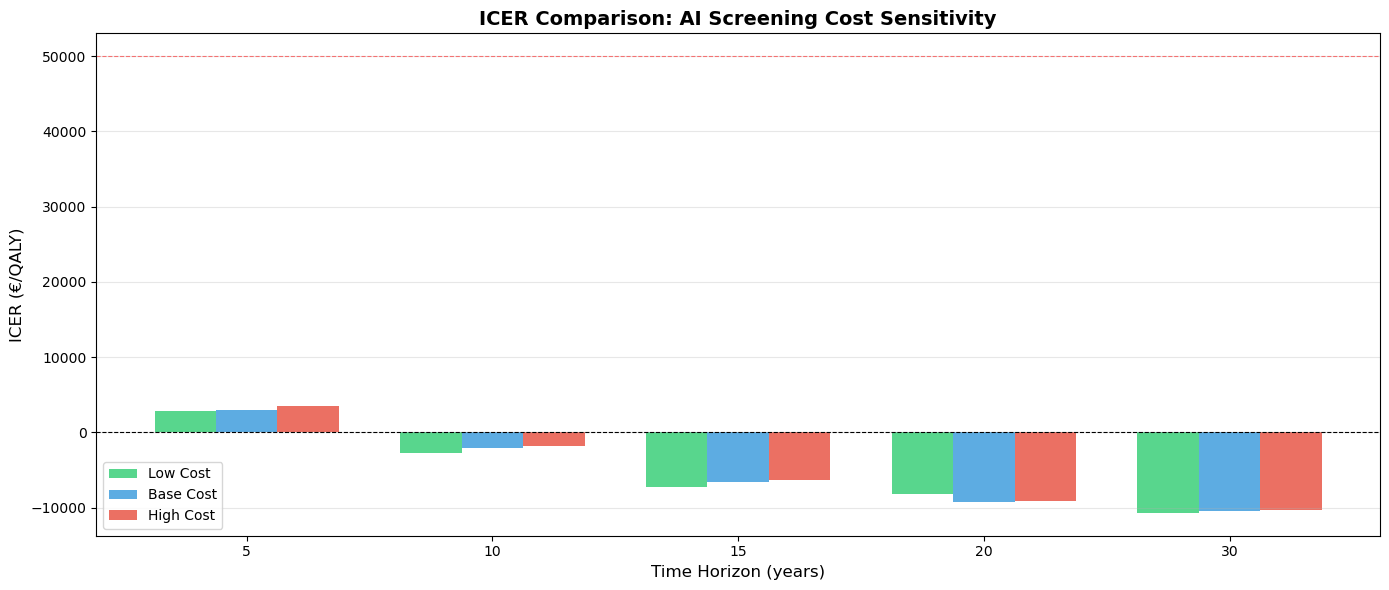

✓ ICER comparison plot saved to ../data/ai_cost_icer_comparison.png


In [25]:
fig, ax = plt.subplots(figsize=(14, 6))

time_horizons = [5, 10, 15, 20, 30]
icers_low = [results_low['comprehensive_results'][f'{t}_years']['summary']['icer_mean'] for t in time_horizons]
icers_base = [results_base['comprehensive_results'][f'{t}_years']['summary']['icer_mean'] for t in time_horizons]
icers_high = [results_high['comprehensive_results'][f'{t}_years']['summary']['icer_mean'] for t in time_horizons]

x = np.arange(len(time_horizons))
width = 0.25

bars1 = ax.bar(x - width, icers_low, width, label='Low Cost', alpha=0.8, color='#2ecc71')
bars2 = ax.bar(x, icers_base, width, label='Base Cost', alpha=0.8, color='#3498db')
bars3 = ax.bar(x + width, icers_high, width, label='High Cost', alpha=0.8, color='#e74c3c')

ax.set_xlabel('Time Horizon (years)', fontsize=12)
ax.set_ylabel('ICER (€/QALY)', fontsize=12)
ax.set_title('ICER Comparison: AI Screening Cost Sensitivity', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(time_horizons)
ax.legend()
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
ax.axhline(y=50000, color='red', linestyle='--', linewidth=0.8, alpha=0.5, label='€50k threshold')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../data/ai_cost_icer_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ ICER comparison plot saved to ../data/ai_cost_icer_comparison.png")

### Probability of Cost-Effectiveness Comparison

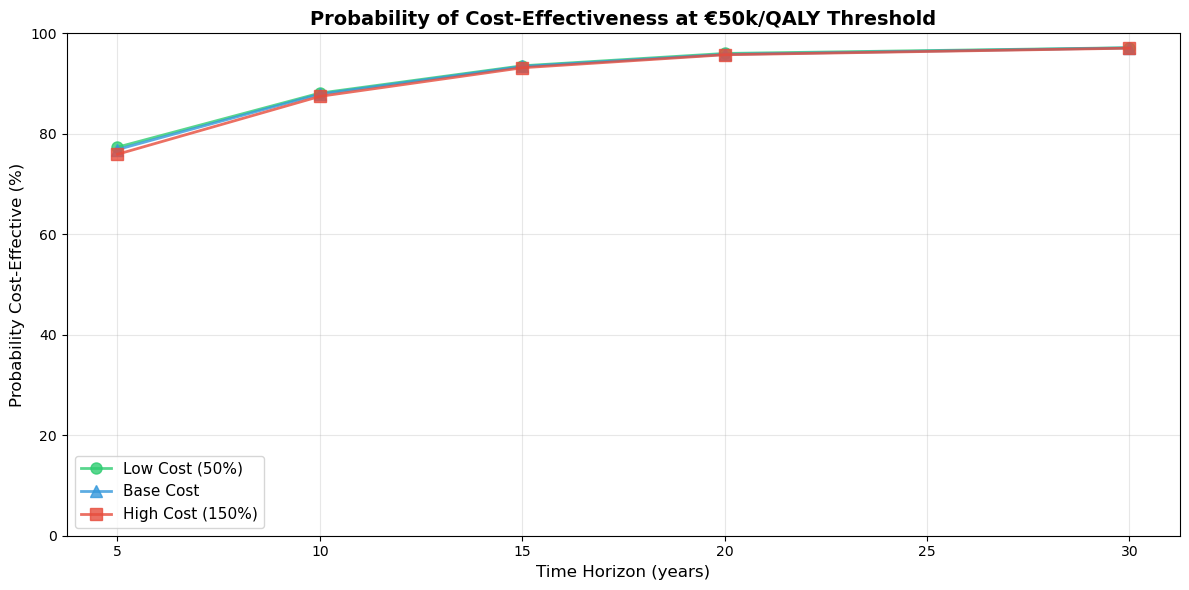

✓ Probability CE comparison plot saved to ../data/ai_cost_prob_ce_comparison.png


In [26]:
fig, ax = plt.subplots(figsize=(12, 6))

prob_ce_low = [results_low['comprehensive_results'][f'{t}_years']['summary']['prob_cost_effective_50k'] for t in time_horizons]
prob_ce_base = [results_base['comprehensive_results'][f'{t}_years']['summary']['prob_cost_effective_50k'] for t in time_horizons]
prob_ce_high = [results_high['comprehensive_results'][f'{t}_years']['summary']['prob_cost_effective_50k'] for t in time_horizons]

ax.plot(time_horizons, prob_ce_low, marker='o', linewidth=2, markersize=8, label='Low Cost (50%)', alpha=0.8, color='#2ecc71')
ax.plot(time_horizons, prob_ce_base, marker='^', linewidth=2, markersize=8, label='Base Cost', alpha=0.8, color='#3498db')
ax.plot(time_horizons, prob_ce_high, marker='s', linewidth=2, markersize=8, label='High Cost (150%)', alpha=0.8, color='#e74c3c')

ax.set_xlabel('Time Horizon (years)', fontsize=12)
ax.set_ylabel('Probability Cost-Effective (%)', fontsize=12)
ax.set_title('Probability of Cost-Effectiveness at €50k/QALY Threshold', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)
ax.set_ylim(0, 100)

plt.tight_layout()
plt.savefig('../data/ai_cost_prob_ce_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Probability CE comparison plot saved to ../data/ai_cost_prob_ce_comparison.png")

### Incremental Costs by AI Screening Cost

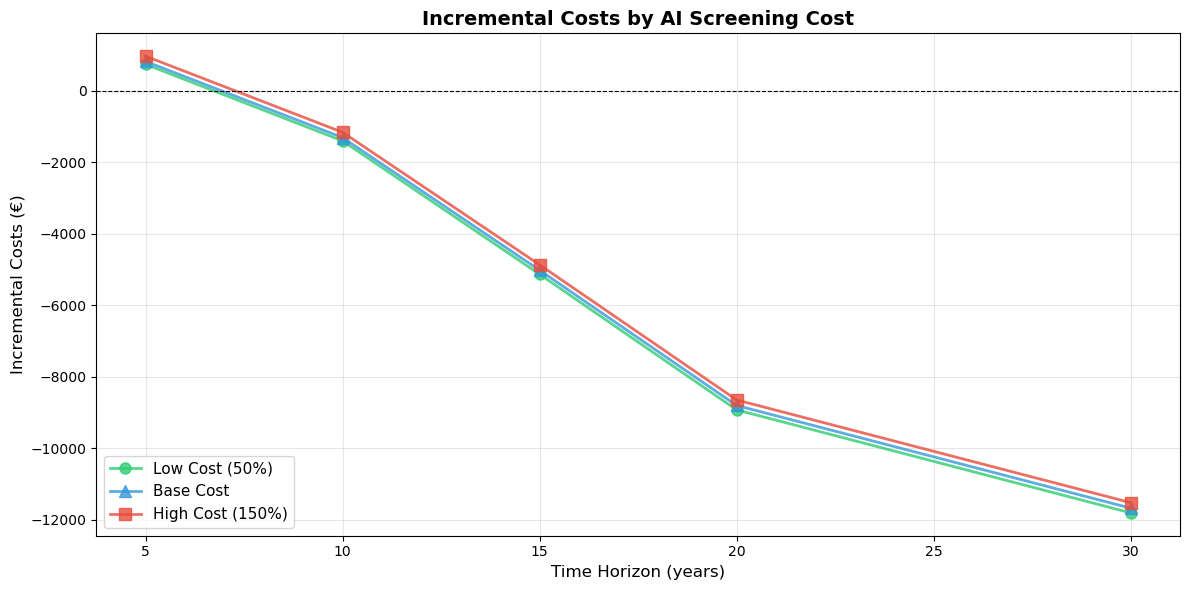

✓ Incremental costs plot saved to ../data/ai_cost_incremental_costs.png


In [27]:
fig, ax = plt.subplots(figsize=(12, 6))

costs_low = [results_low['comprehensive_results'][f'{t}_years']['summary']['incremental_cost_mean'] for t in time_horizons]
costs_base = [results_base['comprehensive_results'][f'{t}_years']['summary']['incremental_cost_mean'] for t in time_horizons]
costs_high = [results_high['comprehensive_results'][f'{t}_years']['summary']['incremental_cost_mean'] for t in time_horizons]

ax.plot(time_horizons, costs_low, marker='o', linewidth=2, markersize=8, label='Low Cost (50%)', alpha=0.8, color='#2ecc71')
ax.plot(time_horizons, costs_base, marker='^', linewidth=2, markersize=8, label='Base Cost', alpha=0.8, color='#3498db')
ax.plot(time_horizons, costs_high, marker='s', linewidth=2, markersize=8, label='High Cost (150%)', alpha=0.8, color='#e74c3c')

ax.set_xlabel('Time Horizon (years)', fontsize=12)
ax.set_ylabel('Incremental Costs (€)', fontsize=12)
ax.set_title('Incremental Costs by AI Screening Cost', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8)

plt.tight_layout()
plt.savefig('../data/ai_cost_incremental_costs.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Incremental costs plot saved to ../data/ai_cost_incremental_costs.png")

## Summary and Conclusions

In [28]:
print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)

print("\n📊 Files saved:")
print("  - ../data/ai_cost_low_summary.csv")
print("  - ../data/ai_cost_base_summary.csv")
print("  - ../data/ai_cost_high_summary.csv")
print("  - ../data/ai_cost_comparison.csv")
print("  - ../data/ai_cost_icer_comparison.png")
print("  - ../data/ai_cost_prob_ce_comparison.png")
print("  - ../data/ai_cost_incremental_costs.png")

print("\n📈 Key Findings (10-year horizon):")
print(f"  Low AI Cost (50%): ICER = €{res_low['icer_mean']:,.0f}/QALY, Prob CE@€50k = {res_low['prob_cost_effective_50k']:.1f}%")
print(f"  Base AI Cost: ICER = €{res_base['icer_mean']:,.0f}/QALY, Prob CE@€50k = {res_base['prob_cost_effective_50k']:.1f}%")
print(f"  High AI Cost (150%): ICER = €{res_high['icer_mean']:,.0f}/QALY, Prob CE@€50k = {res_high['prob_cost_effective_50k']:.1f}%")

print("\n💡 Interpretation:")
icer_increase = res_high['icer_mean'] - res_low['icer_mean']
cost_increase_pct = ((ai_screening_costs['High'] - ai_screening_costs['Low']) / ai_screening_costs['Low']) * 100
print(f"  A {cost_increase_pct:.0f}% increase in AI screening cost results in:")
print(f"    - ICER increase of €{icer_increase:,.0f}/QALY")
print(f"    - Probability CE change of {res_high['prob_cost_effective_50k'] - res_low['prob_cost_effective_50k']:.1f} percentage points")

if res_low['prob_cost_effective_50k'] > 80:
    print("\n  AI screening remains highly cost-effective even at higher costs.")
elif res_high['prob_cost_effective_50k'] < 50:
    print("\n  AI screening cost-effectiveness is sensitive to screening cost.")
else:
    print("\n  AI screening cost-effectiveness shows moderate sensitivity to screening cost.")

print("\n✓ All three scenarios have been successfully analyzed and compared.")


ANALYSIS COMPLETE

📊 Files saved:
  - ../data/ai_cost_low_summary.csv
  - ../data/ai_cost_base_summary.csv
  - ../data/ai_cost_high_summary.csv
  - ../data/ai_cost_comparison.csv
  - ../data/ai_cost_icer_comparison.png
  - ../data/ai_cost_prob_ce_comparison.png
  - ../data/ai_cost_incremental_costs.png

📈 Key Findings (10-year horizon):
  Low AI Cost (50%): ICER = €-10,697/QALY, Prob CE@€50k = 97.1%
  Base AI Cost: ICER = €-10,457/QALY, Prob CE@€50k = 97.1%
  High AI Cost (150%): ICER = €-10,305/QALY, Prob CE@€50k = 97.0%

💡 Interpretation:
  A 137% increase in AI screening cost results in:
    - ICER increase of €392/QALY
    - Probability CE change of -0.1 percentage points

  AI screening remains highly cost-effective even at higher costs.

✓ All three scenarios have been successfully analyzed and compared.
